# Generation of 1D profiles to percolate liquid through

I want to generate a range of 1D profiles for exploring how variability impact porosity. To do this I will build on the example of [Lukas Mosser](https://github.com/LukasMosser/roeth_tarantola_blog_series) and instead of having layers of velocity, I will have layers of permeability.

Fluid will migrate vertically through my matrix by D'Arcy flow,
$$ \partial_{t} \phi + \partial_{z} (\phi v) = 0 $$
where,
$$ \phi v = \frac{k}{\eta} \Delta\rho g $$
In these coupled equations the permeability, $k$, is a function of the porosity, and to keep things simple I will assume it is just a linear function,
$$ k = k_{0}\phi^{2} $$
where $k_{0}$ is the permeability coefficient.

Therfore the non-linear equation to solve is,
$$ \partial_{t}\phi + \frac{2k_{o}\phi\Delta\rho g}{\eta} \partial_{z}{\phi} = 0 $$

So just for fun, I will build a series of 1D profiles and then percolate fluid through them to see how sensative the model is to spatial variation in $k_{0}$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch

### The layers

I will have 5 layers each being 10 km thick. Permeability will be linearly increasing with depth.

In [2]:
lx = 10000 # length of model space (m)
nx = 100 # number of cells in x
lz = 50000 # depth of model space (m)
nz = 5 # number of cells in z
dz = int(lz/nz) # discretisation
dx = lx/nx # discretisation
n_layers = 5 # number of layers
k0 = 1e-7 # permeability at top
dk_const = 1e-8 # permeability increase

### Define the probability distribution

Just start with a uniform distribution using pytorch. Set the initial seed to 42.

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

dk = torch.distributions.Uniform(low=-1,high=1)

Because I am using pytorch to generate the model I will create a container to store the permeabilities in

In [4]:
model = torch.ones(nz,1)

kl = k0 + dk_const*dk.sample()
for i in range(0, n_layers):
    model[dz*i:dz*(i+1)] = kl
    kl = (kl - dk_const) + dk_const*dk.sample()
    print("Layer ", i+1, " at depth ", dz*i, "[m] has permeability of %3.1e" % kl.item())

Layer  1  at depth  0 [m] has permeability of 1.1e-07
Layer  2  at depth  10000 [m] has permeability of 9.4e-08
Layer  3  at depth  20000 [m] has permeability of 9.3e-08
Layer  4  at depth  30000 [m] has permeability of 8.1e-08
Layer  5  at depth  40000 [m] has permeability of 7.3e-08


In an effort to improve lets make that into a function, but wihtout the linear decrease

In [5]:
def sample_model_N_times(k0,dk_const,n_layers,nz,N):
    models = []
    permeabilities = []
    for i in range(N):
        model_true = torch.ones(nz,1)

        kl = k0 + dk_const*dk.sample()
        k_temp = []
        for i in range(0, n_layers):
            k_temp.append(kl)
            model_true[dz*i:dz*(i+1)] = kl
            kl = k0 + dk_const*dk.sample()
        permeabilities.append(torch.stack(k_temp, 0))
        models.append(model_true)
        
    models_th = torch.stack(models, 0)
    permeabilities_th = torch.stack(permeabilities, 0) 
    return models_th, permeabilities_th

In [6]:
earth_models_th, layer_permeabilities_th = sample_model_N_times(k0,dk_const,n_layers,nz,1)

print(earth_models_th.size())
print(layer_permeabilities_th.size())
print(layer_permeabilities_th)

torch.Size([1, 5, 1])
torch.Size([1, 5])
tensor([[9.5131e-08, 1.0587e-07, 1.0882e-07, 9.2664e-08, 1.0869e-07]])


Call the function to make a nice number of models, say 100:

In [7]:
N = 100
dk_const = 1e-7
earth_models_th, layer_permeabilities_th = sample_model_N_times(k0,dk_const,n_layers,nz,N)

Now plot them:

In [8]:
def plot_profiles(y,layers,N,dz):
    for j in range(N):
        x = []
        z = []
        z_ = 0
        for i in range(layers):
            z.append(z_)
            z_ += dz
            x.append(y.numpy()[j][i])
            z.append(z_)
            x.append(y.numpy()[j][i])

        plt.plot(x,z,'black')

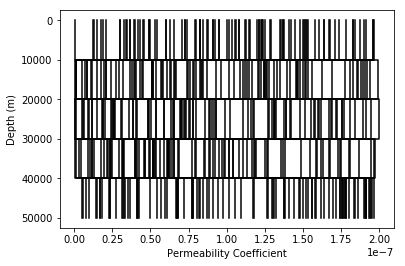

In [9]:
plot_profiles(layer_permeabilities_th,n_layers,N,dz)
plt.gca().invert_yaxis()
plt.xlabel('Permeability Coefficient')
plt.ylabel('Depth (m)')
plt.show()

Cool, now to let fluid percolate through the 1D column... TO DO: translate the TVD matlab function to python...

In [10]:
from utils import interpolate_model,advection_1d

Physical parameters for my fluid

In [11]:
Drho = 1000 # kg/m3
g = 9.81 # m/s2
eta = 0.1 # Pa s

In [12]:
N = 1
earth_models_th, layer_permeabilities_th = sample_model_N_times(k0,dk_const,n_layers,nz,N)

In [13]:
def advection_test(var,vel,dz,dt,NN):

    """
    A TVD scheme for the advection of fluid 
    
    """
        
    # ghost cells required of my artificial boundary conditions:
    # non-reflecting Neumann type boundary conditions are implemented
    vargh = np.insert(var, [0,NN], [var[0],var[-1]])  
    velgh = np.insert(vel, [0,NN], [vel[0],vel[-1]])
        
    theta = np.ones(NN+2)
    theta[np.where(velgh<0)] = -1
    
    # calculate slopes for the flux limiter (phi)
    TVD_r = vargh[1:]
    TVD_r2 = np.insert(vargh[2:],np.shape(vargh[2:])[0],vargh[-1])
    TVD_m = vargh[:-1]
    TVD_l = np.insert(vargh[:-2],0,vargh[0])
            
    r_TVDup = (TVD_r2-TVD_r)/(TVD_r-TVD_m)
    r_TVDdown = (TVD_m-TVD_l)/(TVD_r-TVD_m)
    
    r_TVD = r_TVDdown
    r_TVD[np.where(theta[1:]<0)] = r_TVDup[np.where(theta[1:]<0)]
    r_TVD[np.where(np.diff(TVD_m)==0)] = 1
    r_TVD[0] = 1
    r_TVD[-1] = 1
                   
    # define Flux Limiter function (Van Leer)
    phi = (r_TVD + np.abs(r_TVD))/(1 + np.abs(r_TVD))
    phi_r = phi[1:]
    phi_l = phi[:-1]
    
    # think about my ghost cells
    TVD_r = vargh[2:]
    TVD_l = vargh[:-2]
    
    # compute fluxes for TVD
    F_rl = .5*((1+theta[1:-1])*vel*var + (1-theta[1:-1])*vel*TVD_r)
    F_rh = .5*vel*(var + TVD_r) - .5*vel*vel*dt/dz*(TVD_r-var)
    
    F_ll = .5*((1+theta[1:-1])*vel*TVD_l + (1-theta[1:-1])*vel*var)
    F_lh = .5*vel*(TVD_l+var) - .5*vel*vel*dt/dz*(var-TVD_l)
    
    # do the job
    F_right = F_rl + phi_r*(F_rh - F_rl)
    F_left  = F_ll + phi_l*(F_lh - F_ll)
    
    vari = var - dt*(F_right-F_left)/dz
        
    # might want to add a check for imaginary numbers...
    
    return vari

<IPython.core.display.Javascript object>


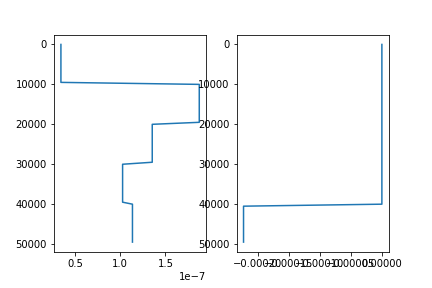

In [61]:
nnz = 100 # depth discretisation
ddz = lz/nnz

z,k = interpolate_model(layer_permeabilities_th,n_layers,N,dz,lz,nnz)
phi_ = np.zeros(nnz)
phi_[np.where(z>40000)] = 0.01
vel = -2*Drho*g*k*phi_/eta

plt.figure()
plt.subplot(1,2,1)
plt.plot(k,z)
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.plot(vel,z)
plt.gca().invert_yaxis()
plt.show()

<IPython.core.display.Javascript object>


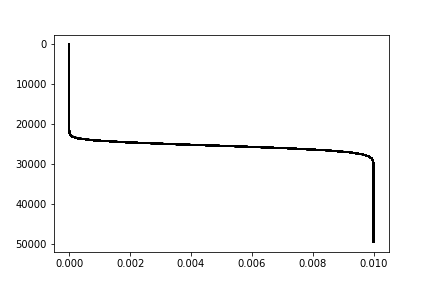

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time

dtnom = 1e6
nt = 100
ts = []
t_ = 0

fig,ax = plt.subplots(1,1)
plt.gca().invert_yaxis()

for t in range(nt):
    #vel = -2*Drho*g*k*phi_/eta
    vel = -Drho*g*k/eta
    phi_,dt = advection_1d(phi_,vel,ddz,dtnom,nnz)
    t_ += dt
    ts.append(t_)
    
    for line in ax.lines:
        line.set_xdata(phi_)
        line.set_ydata(z)
    ax.plot(phi_,z,'k')
    fig.canvas.draw()
    time.sleep(1)

    

In [47]:
print(phi_[-1])

0.01


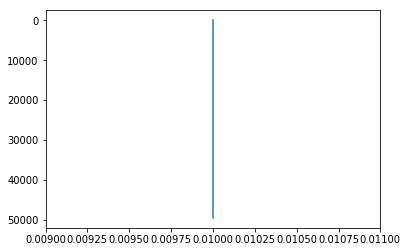

In [48]:
plt.plot(phi_,z)
plt.gca().invert_yaxis()
plt.xlim(0.009,0.011)
plt.show()

<IPython.core.display.Javascript object>


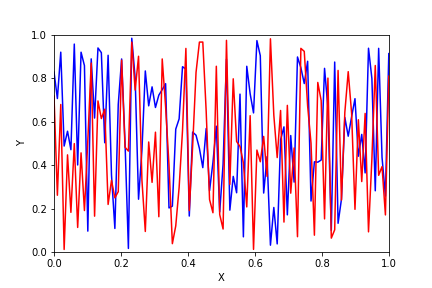

<IPython.core.display.Javascript object>


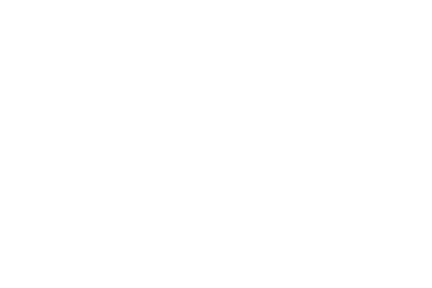

In [49]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)